In [1]:
# lib
import sys

sys.path.append("..")

# set cwd one up
import os

os.chdir("..")
path = "data/hes/Hes1_example.csv"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import gpflow

print(gpflow.config.default_positive_bijector())
print(gpflow.config.default_positive_minimum())
# gpflow.config.set_default_positive_bijector("exp")
# print(gpflow.config.default_positive_bijector())

softplus
0.0


In [3]:
from gpcell import OscillatorDetector
from gpcell.backend.priors import (
    sd_ou_priors,
    sd_ouosc_priors,
)

In [4]:
params = {
    "plots": ["MCMC", "MCMC_marginal"],
    "verbose": True,
    "joblib": True,
    "ou_prior_gen": sd_ou_priors,
    "ouosc_prior_gen": sd_ouosc_priors,
}
od: OscillatorDetector = OscillatorDetector.from_file(
    path, "Time (h)", "Background", "Cell", params
)
od.fit(methods="MCMC")



Starting Oscillator Detector...

Overriding default value for verbose
Overriding default value for plots
Overriding default value for joblib
Overriding default value for ou_prior_gen
Overriding default value for ouosc_prior_gen

Loaded data with 12 cells and 4 background noise models
Plots: on

Fitting background noise...
Background noise results:
Standard deviation: 7.302221575486058

Fitting MCMC...

Small, non-homogenous traces: 12 cells


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  12 out of  12 | elapsed:  1.8min finished
/Users/tsd/Python/GPCell/gpcell/main.py:992: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Unconstrained 1 r_hat: 1.6293832825004202, ess: 6.643884947192205
Unconstrained 2 r_hat: 2.75521965672167, ess: 4.66629086076777
Unconstrained 3 r_hat: 1.55800839480349, ess: 7.207376467943383
Unconstrained 4 r_hat: 1.5001563684713384, ess: 8.026289244438368
Unconstrained 5 r_hat: 1.7046222986248005, ess: 6.317448450686788
Unconstrained 6 r_hat: 1.8145725088927958, ess: 5.887346355194678
Unconstrained 7 r_hat: 1.6406888312043821, ess: 6.710023090697847
Unconstrained 8 r_hat: 1.762172811953635, ess: 6.041076915238426
Unconstrained 9 r_hat: 2.0318509399623568, ess: 5.662758501555909
Unconstrained 10 r_hat: 1.6112065923780297, ess: 6.9779835448302565
Unconstrained 11 r_hat: 2.5560242775234308, ess: 4.8213549228482435
Unconstrained 12 r_hat: 1.0848196515932083, ess: 116.61814150432092
Shape of beta samples: (4000,)
Cell 1 prior mass: 0.049975462331125146, posterior mass: 0.75
Cell 2 prior mass: 0.049975462331125146, posterior mass: 0.08425
Cell 3 prior mass: 0.049975462331125146, posterior

In [5]:
classified = 0
labels = [1 for _ in range(8)] + [0, 1, 1, 0]

# use bf > 3.0 = 1 to classify
# generate statistics
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
for i, (bf, label) in enumerate(zip(od.bf_list, labels)):
    pred = 1 if bf > 3.0 else 0
    if pred == label:
        classified += 1
        if label == 1:
            true_pos += 1
        else:
            true_neg += 1
    else:
        if label == 1:
            false_neg += 1
        else:
            false_pos += 1
print(f"True Positives: {true_pos}")
print(f"True Negatives: {true_neg}")
print(f"False Positives: {false_pos}")
print(f"False Negatives: {false_neg}")
print(f"Classified: {classified} / {len(labels)}")
print(f"Accuracy: {classified / len(labels)}")


True Positives: 7
True Negatives: 1
False Positives: 1
False Negatives: 3
Classified: 8 / 12
Accuracy: 0.6666666666666666


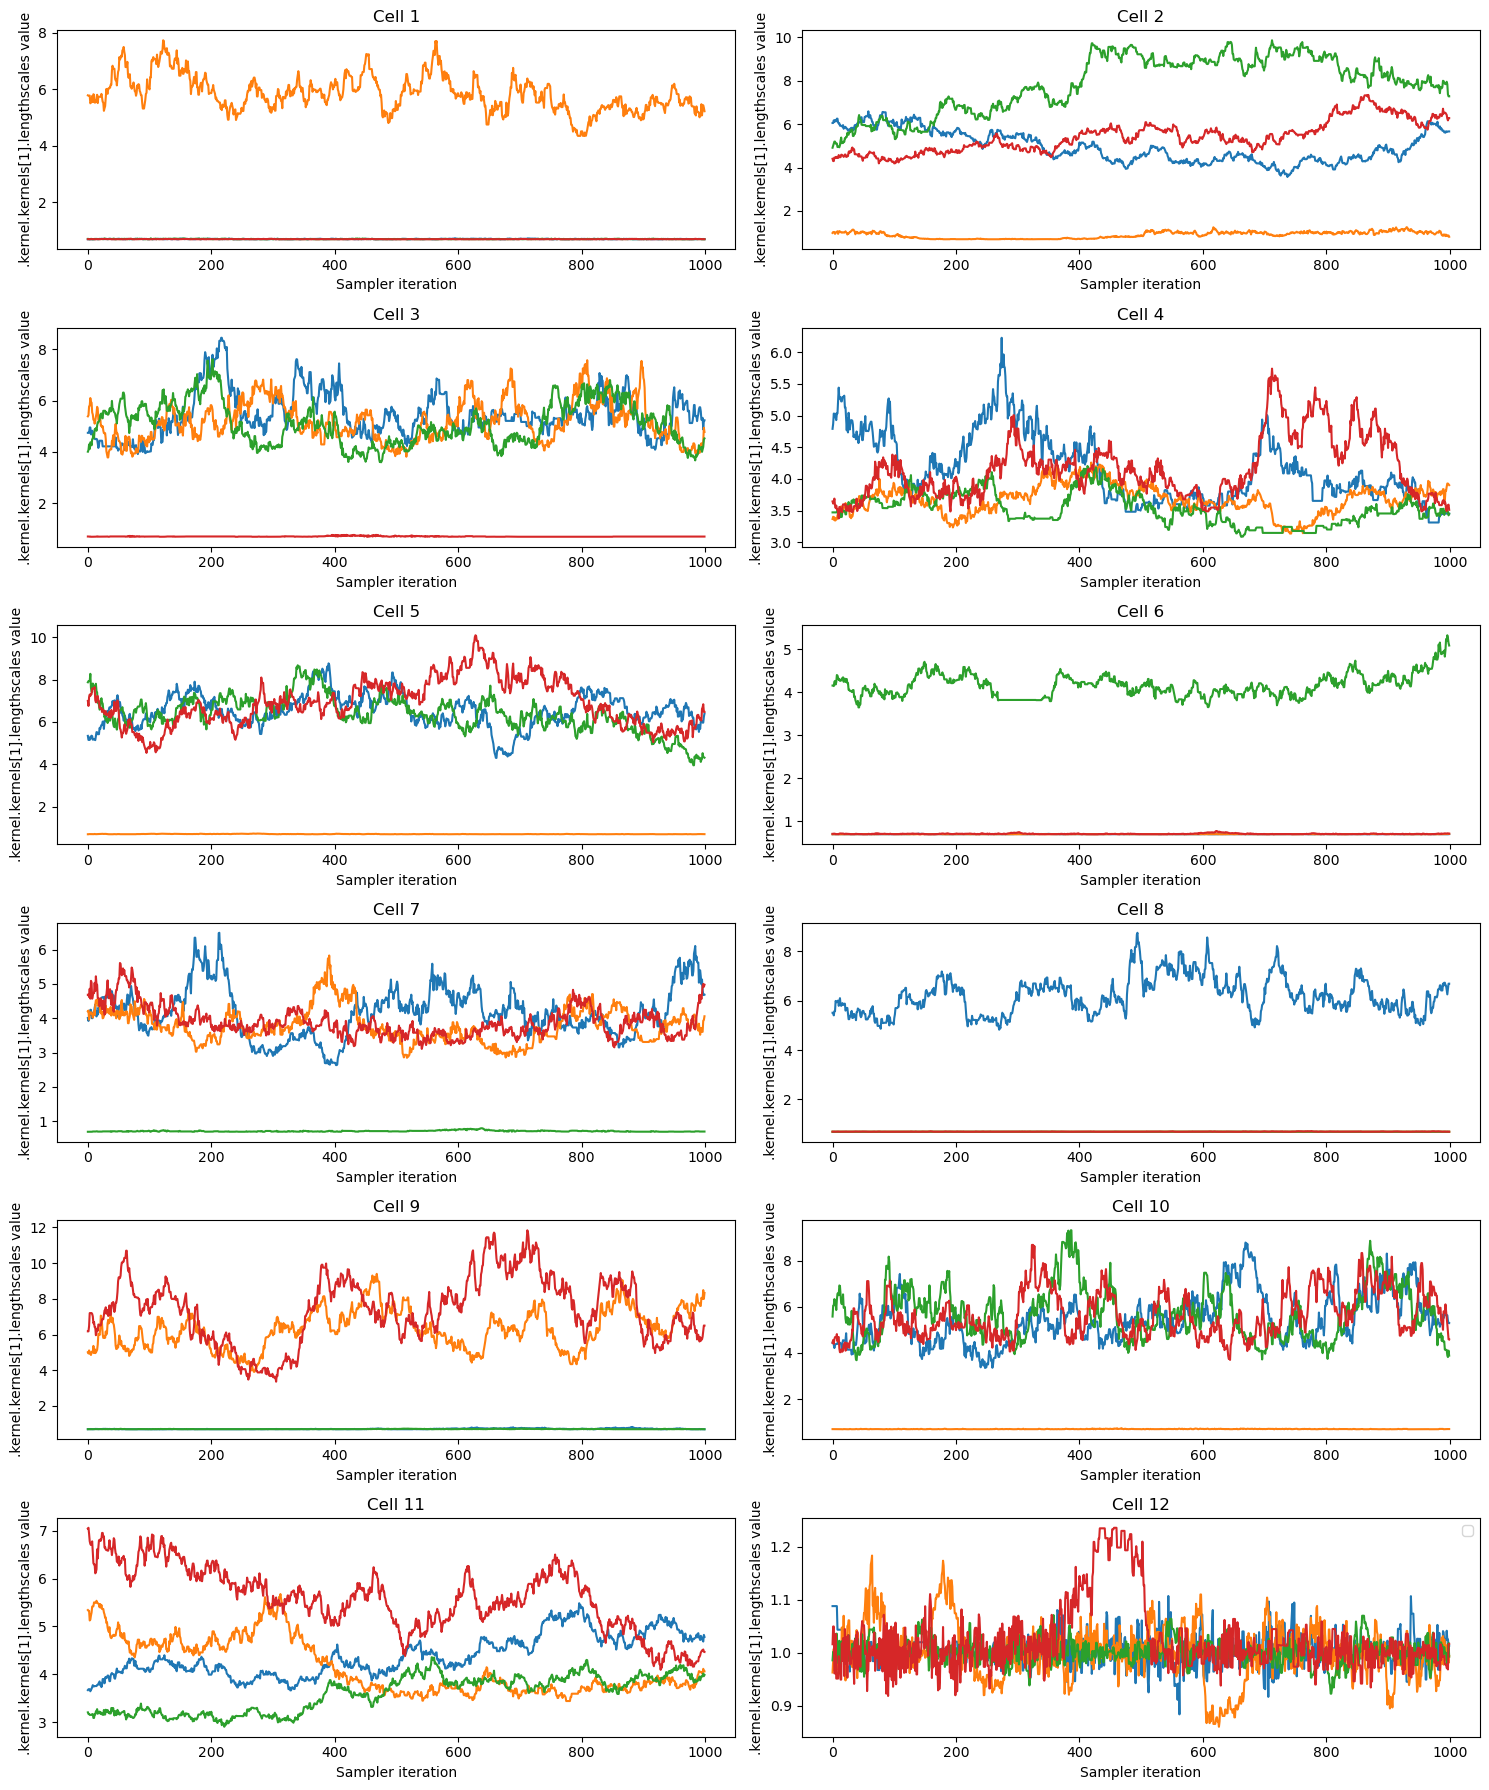

In [6]:
od.mcmc_plot

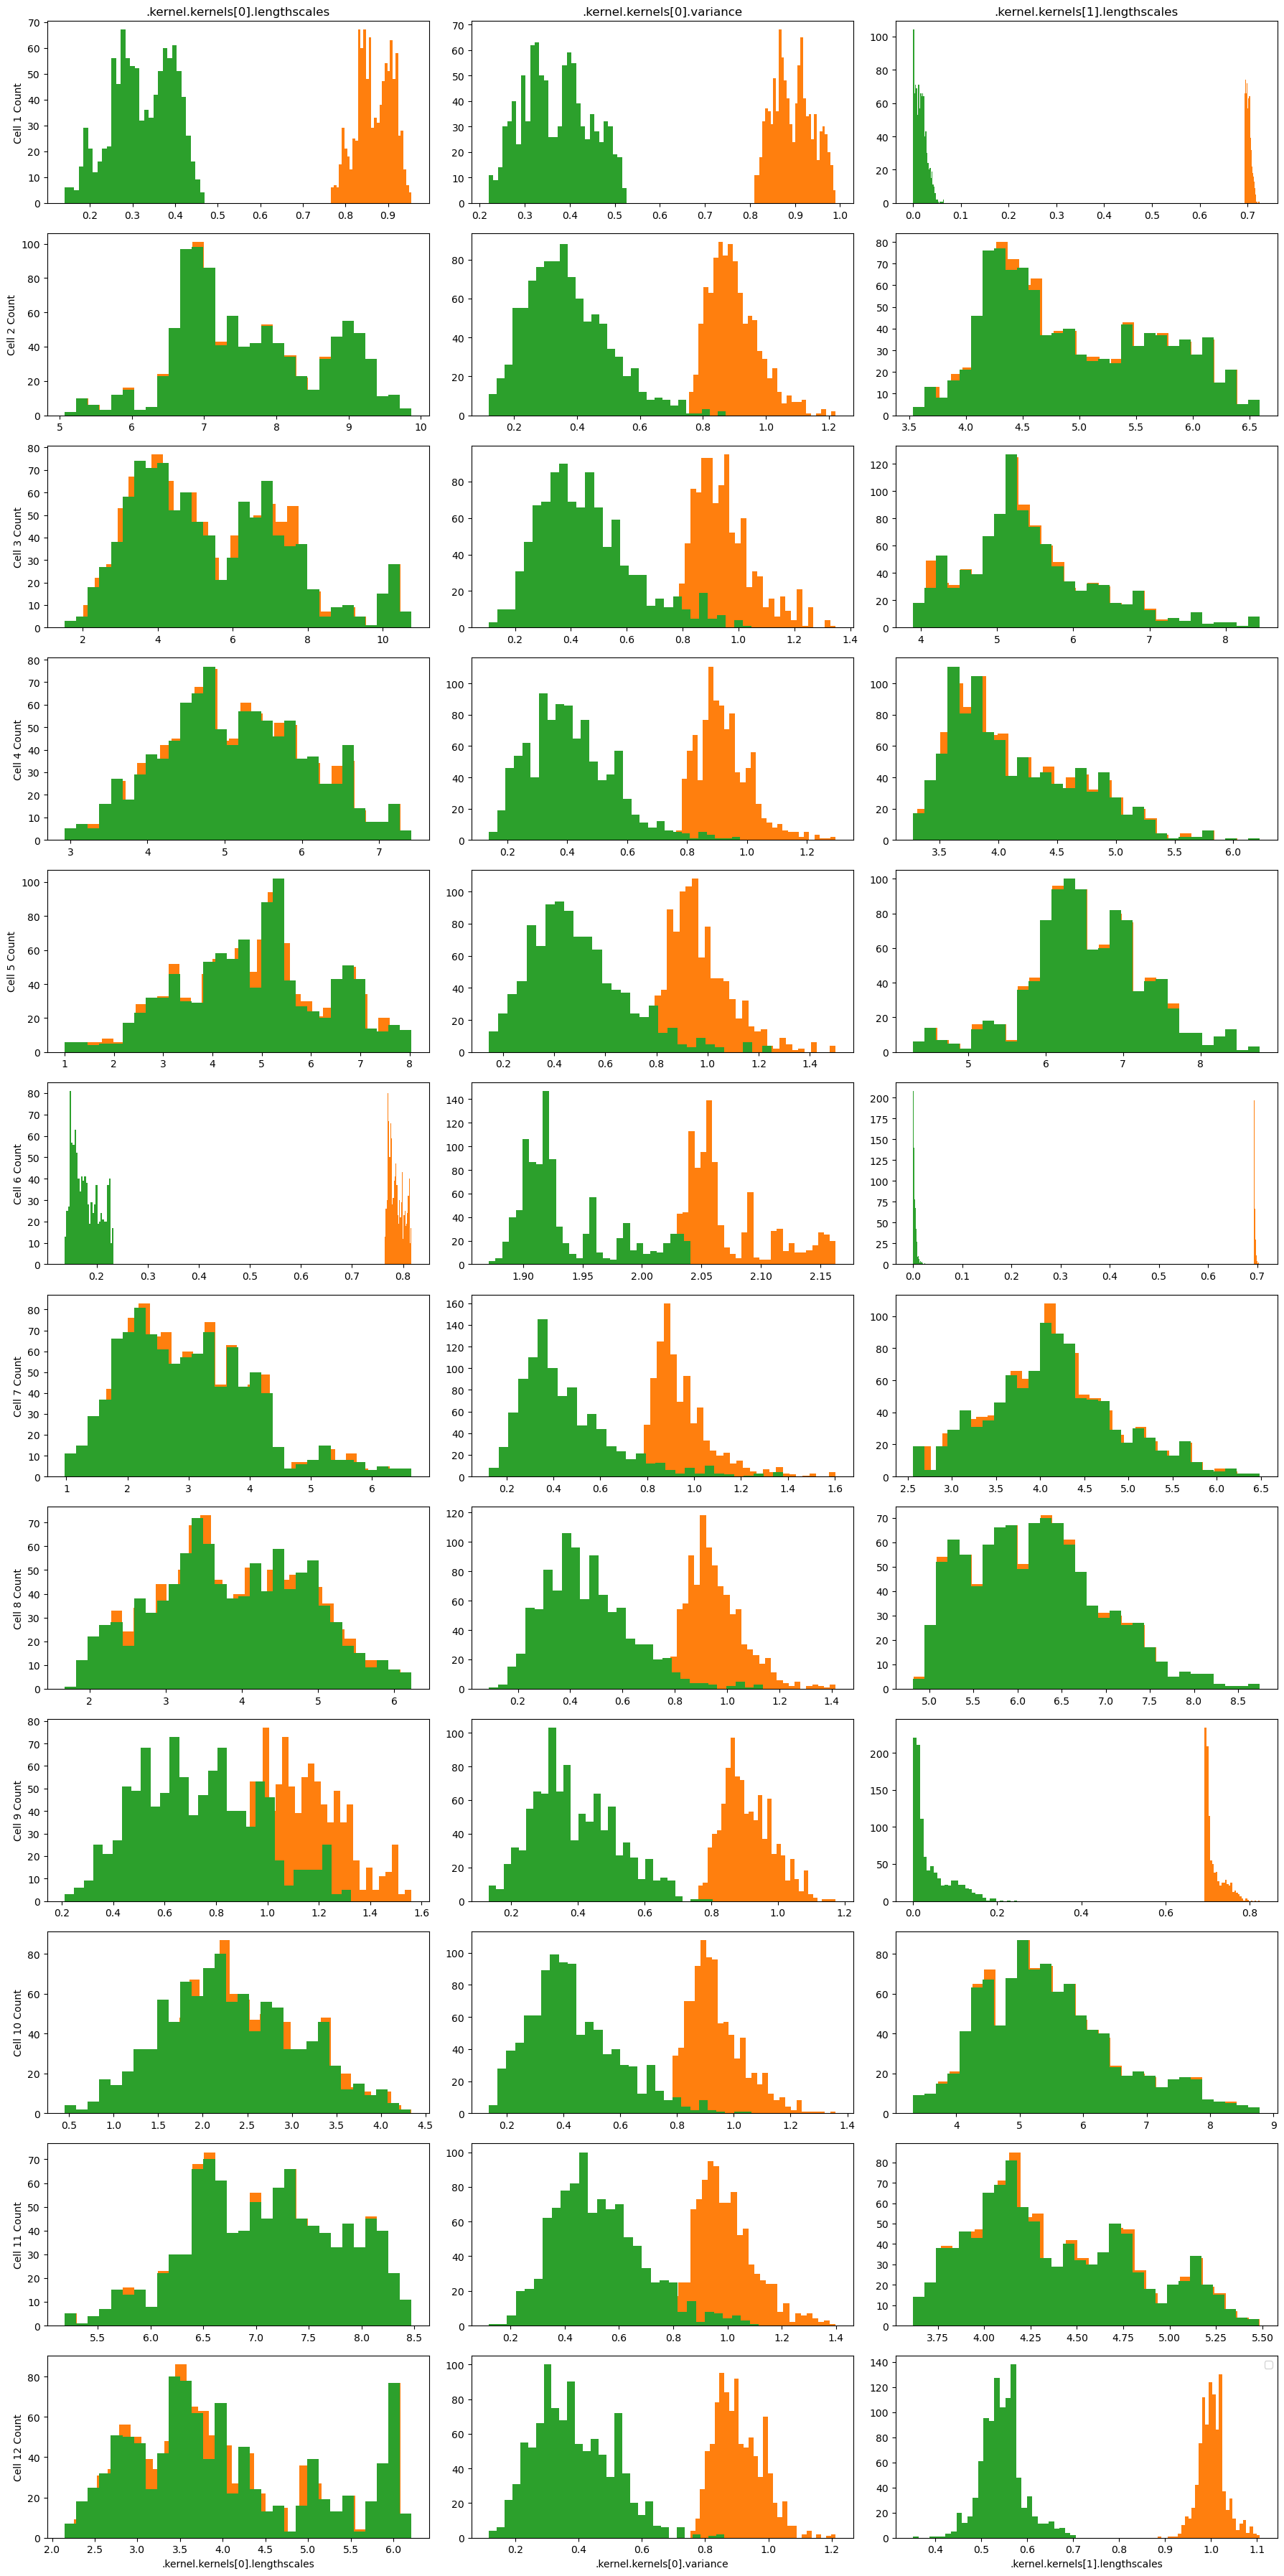

In [7]:
od.marginal_plot

# MCMC Dev

In [ ]:
import numpy as np
from gpcell.utils import load_data

from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt

import pymc as pm
from pymc.gp.cov import ExpQuad, Cosine

import arviz as az
import warnings


# setup
par1 = np.array([300, 1, 0.07, 0.07, 1, 1, 0], dtype=np.float64)
par2 = np.array([100, 3, 0.03, 0.03, 1, 1, 18], dtype=np.float64)
n_cells = 50  # total replicates used in the simulation
t_final_vals = [1500, 600]  # 25/10 hours
noise_vals = [np.sqrt(x) for x in [0.1, 0.5]]

sim_params = [[noise, t_final_vals[0], n_cells] for noise in noise_vals]
sim_params.append([noise_vals[0], t_final_vals[1], n_cells])

path = "data/matlab/"
paths = [
    path + f"noise_{round(noise**2, 2)}_time_{t_final}_rep_{n_cells}.csv"
    for noise, t_final, n_cells in sim_params
]

# load data
params = sim_params[0]
path = paths[0]
noise = params[0]
X, Y = load_data(path, "Time", "Cell")

In [ ]:
def bridge_gp_logZ(
    X,  # array‐like, shape (n,1) or (n,)
    y,  # array‐like, same length as X
    noise_sd,  # float, known observation noise std. dev.
    model="ou",  # "ou" or "ouosc"
    draws=1000,  # posterior draws per chain
    tune=1000,  # tuning steps per chain
    chains=4,  # number of parallel chains
    split_frac=0.5,  # fraction of draws for proposal‐fit
    plot_trace=False,  # whether to plot MCMC traces of the GP hyperparams
):
    # 1. hyperparameter names/bounds
    if model == "ou":
        varnames = ["ls", "amp"]
        bounds = {"ls": (0.1, 2.0), "amp": (0.1, 2.0)}
        use_ls2 = False
    elif model == "ouosc":
        varnames = ["ls", "amp", "ls2"]
        bounds = {"ls": (0.1, 2.0), "amp": (0.1, 2.0), "ls2": (0.1, 4.0)}
        use_ls2 = True
    else:
        raise ValueError("model must be 'ou' or 'ouosc'")

    # 2. Build & sample
    with pm.Model() as gp_model:
        ls = pm.Uniform(
            "ls", lower=bounds["ls"][0], upper=bounds["ls"][1], default_transform=None
        )
        amp = pm.Uniform(
            "amp",
            lower=bounds["amp"][0],
            upper=bounds["amp"][1],
            default_transform=None,
        )
        cov = amp**2 * ExpQuad(1, ls=ls)
        if use_ls2:
            ls2 = pm.Uniform(
                "ls2",
                lower=bounds["ls2"][0],
                upper=bounds["ls2"][1],
                default_transform=None,
            )
            cov *= Cosine(1, ls=ls2)

        gp = pm.gp.Marginal(cov_func=cov)
        gp.marginal_likelihood("y_obs", X=X, y=y, sigma=noise_sd)

        # return InferenceData instead of MultiTrace
        idata = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=0.9,
            return_inferencedata=True,
            cores=14,
        )

        if plot_trace:
            # now idata is ArviZ InferenceData
            pm.plot_trace(idata, var_names=varnames)
            plt.tight_layout()
            plt.show()

    # 3. extract the posterior samples as an (N, len(varnames)) array
    posterior = np.column_stack(
        [idata.posterior[var].values.flatten() for var in varnames]
    )

    # 4. split for proposal fit vs eval
    N = int(posterior.shape[0] * split_frac)
    fit_draws = posterior[:N]
    eval_draws = posterior[N:]

    # 5. Gaussian proposal
    mu_prop = fit_draws.mean(axis=0)
    cov_prop = np.cov(fit_draws, rowvar=False)
    proposal = multivariate_normal(mean=mu_prop, cov=cov_prop)

    # 6. compile log-prob on free_RVs
    logp_fn = gp_model.compile_logp()
    free_names = [rv.name for rv in gp_model.free_RVs]

    # 7. evaluate log post & log q
    pts = [dict(zip(free_names, θ)) for θ in eval_draws]
    log_post = np.array([logp_fn(pt) for pt in pts])
    log_q = proposal.logpdf(eval_draws)

    # 8. stable bridge-sampling
    def bridge_logZ_iter(log_post, log_q, max_iters=100, tol=1e-6):
        logZ = 0.0
        n = len(log_post)
        for _ in range(max_iters):
            a = log_post - log_q - logZ
            b = log_q - log_post + logZ
            lm_inv_w1 = logsumexp(-a) - np.log(n)
            lm_w2 = logsumexp(b) - np.log(n)
            new_logZ = lm_inv_w1 - lm_w2
            if abs(new_logZ - logZ) < tol:
                break
            logZ = new_logZ
        return logZ

    return bridge_logZ_iter(log_post, log_q)


In [ ]:
# only run for two chains
X_list, Y_list = X[:2], Y[:2]
logZ_ou, logZ_ouosc = [], []
for x, y in zip(X_list, Y_list):
    logZ_ou.append(
        bridge_gp_logZ(
            x.reshape(-1, 1),
            y,
            noise,
            model="ou",
            draws=5000,
            tune=1000,
            chains=10,
            split_frac=0.5,
            plot_trace=True,
        )
    )
    logZ_ouosc.append(
        bridge_gp_logZ(
            x.reshape(-1, 1),
            y,
            noise,
            model="ouosc",
            draws=5000,
            tune=1000,
            chains=10,
            split_frac=0.5,
            plot_trace=True,
        )
    )

print("logZ_ou:", logZ_ou)
print("logZ_ouosc:", logZ_ouosc)
BF_array = np.exp(np.array(logZ_ouosc) - np.array(logZ_ou))
print("Bayes Factor (ouosc vs ou):", BF_array)

In [ ]:
# def fit_model(
#     x,
#     y,
#     noise_sd,  # float, known observation noise std. dev.
#     model="ou",  # "ou" or "ouosc"
#     draws=1000,  # posterior draws per chain
#     tune=1000,  # tuning steps per chain
#     chains=4,  # number of parallel chains
#     split_frac=0.5,  # fraction of draws for proposal‐fit
#     plot_trace=False,  # whether to plot MCMC traces of the GP hyperparams
# ):
#     # 1. hyperparameter names/bounds
#     if model == "ou":
#         bounds = {"ls": (0.1, 2.0), "amp": (0.1, 2.0)}
#         use_ls2 = False
#     elif model == "ouosc":
#         bounds = {"ls": (0.1, 2.0), "amp": (0.1, 2.0), "ls2": (0.1, 4.0)}
#         use_ls2 = True
#     else:
#         raise ValueError("model must be 'ou' or 'ouosc'")

#     # 2. Build & sample
#     with pm.Model() as gp_model:
#         ls = pm.Uniform(
#             "ls", lower=bounds["ls"][0], upper=bounds["ls"][1], default_transform=None
#         )
#         amp = pm.Uniform(
#             "amp",
#             lower=bounds["amp"][0],
#             upper=bounds["amp"][1],
#             default_transform=None,
#         )
#         cov = amp**2 * ExpQuad(1, ls=ls)
#         if use_ls2:
#             ls2 = pm.Uniform(
#                 "ls2",
#                 lower=bounds["ls2"][0],
#                 upper=bounds["ls2"][1],
#                 default_transform=None,
#             )
#             cov *= Cosine(1, ls=ls2)

#         gp = pm.gp.Marginal(cov_func=cov)
#         gp.marginal_likelihood("y_obs", X=x, y=y, sigma=noise_sd)

#         mtrace = pm.sample(
#             draws=draws,
#             tune=tune,
#             chains=chains,
#             target_accept=0.9,
#             return_inferencedata=False,
#             cores=14,
#         )

#     return mtrace, gp_model


# def Marginal_llk(mtrace, model=None, logp=None, maxiter=1000):
#     """The Bridge Sampling Estimator of the Marginal Likelihood.

#     Parameters
#     ----------
#     mtrace : MultiTrace, result of MCMC run
#     model : PyMC Model
#         Optional model. Default None, taken from context.
#     logp : Model Log-probability function, read from the model by default
#     maxiter : Maximum number of iterations

#     Returns
#     -------
#     marg_llk : Estimated Marginal log-Likelihood.
#     """
#     r0, tol1, tol2 = 0.5, 1e-10, 1e-4

#     model = modelcontext(model)
#     if logp is None:
#         logp = model.logp_array
#     vars = model.free_RVs

#     # Split the samples into two parts
#     # Use the first 50% for fiting the proposal distribution and the second 50%
#     # in the iterative scheme.
#     len_trace = len(mtrace)
#     nchain = mtrace.nchains

#     N1_ = len_trace // 2
#     N1 = N1_ * nchain
#     N2 = len_trace * nchain - N1

#     neff_list = dict()  # effective sample size

#     arraysz = model.bijection.ordering.size
#     samples_4_fit = np.zeros((arraysz, N1))
#     samples_4_iter = np.zeros((arraysz, N2))
#     # matrix with already transformed samples
#     for var in vars:
#         varmap = model.bijection.ordering.by_name[var.name]
#         # for fitting the proposal
#         x = mtrace[:N1_][var.name]
#         samples_4_fit[varmap.slc, :] = x.reshape(
#             (x.shape[0], np.prod(x.shape[1:], dtype=int))
#         ).T
#         # for the iterative scheme
#         x2 = mtrace[N1_:][var.name]
#         samples_4_iter[varmap.slc, :] = x2.reshape(
#             (x2.shape[0], np.prod(x2.shape[1:], dtype=int))
#         ).T
#         # effective sample size of samples_4_iter, scalar
#         neff_list.update(pm.effective_n(mtrace[N1_:], varnames=[var.name]))

#     # median effective sample size (scalar)
#     neff = pm.stats.dict2pd(neff_list, "temp").median()

#     # get mean & covariance matrix and generate samples from proposal
#     m = np.mean(samples_4_fit, axis=1)
#     V = np.cov(samples_4_fit)
#     L = chol(V, lower=True)

#     # Draw N2 samples from the proposal distribution
#     gen_samples = m[:, None] + dot(L, st.norm.rvs(0, 1, size=samples_4_iter.shape))

#     # Evaluate proposal distribution for posterior & generated samples
#     q12 = st.multivariate_normal.logpdf(samples_4_iter.T, m, V)
#     q22 = st.multivariate_normal.logpdf(gen_samples.T, m, V)

#     # Evaluate unnormalized posterior for posterior & generated samples
#     q11 = np.asarray([logp(point) for point in samples_4_iter.T])
#     q21 = np.asarray([logp(point) for point in gen_samples.T])

#     # Iterative scheme as proposed in Meng and Wong (1996) to estimate
#     # the marginal likelihood
#     def iterative_scheme(q11, q12, q21, q22, r0, neff, tol, maxiter, criterion):
#         l1 = q11 - q12
#         l2 = q21 - q22
#         lstar = np.median(l1)  # To increase numerical stability,
#         # subtracting the median of l1 from l1 & l2 later
#         s1 = neff / (neff + N2)
#         s2 = N2 / (neff + N2)
#         r = r0
#         r_vals = [r]
#         logml = np.log(r) + lstar
#         criterion_val = 1 + tol

#         i = 0
#         while (i <= maxiter) & (criterion_val > tol):
#             rold = r
#             logmlold = logml
#             numi = np.exp(l2 - lstar) / (s1 * np.exp(l2 - lstar) + s2 * r)
#             deni = 1 / (s1 * np.exp(l1 - lstar) + s2 * r)
#             if np.sum(~np.isfinite(numi)) + np.sum(~np.isfinite(deni)) > 0:
#                 warnings.warn("""Infinite value in iterative scheme, returning NaN.
#                 Try rerunning with more samples.""")
#             r = (N1 / N2) * np.sum(numi) / np.sum(deni)
#             r_vals.append(r)
#             logml = np.log(r) + lstar
#             i += 1
#             if criterion == "r":
#                 criterion_val = np.abs((r - rold) / r)
#             elif criterion == "logml":
#                 criterion_val = np.abs((logml - logmlold) / logml)

#         if i >= maxiter:
#             return dict(logml=np.NaN, niter=i, r_vals=np.asarray(r_vals))
#         else:
#             return dict(logml=logml, niter=i)

#     # Run iterative scheme:
#     tmp = iterative_scheme(q11, q12, q21, q22, r0, neff, tol1, maxiter, "r")
#     if ~np.isfinite(tmp["logml"]):
#         warnings.warn("""logml could not be estimated within maxiter, rerunning with
#                       adjusted starting value. Estimate might be more variable than usual.""")
#         # use geometric mean as starting value
#         r0_2 = np.sqrt(tmp["r_vals"][-2] * tmp["r_vals"][-1])
#         tmp = iterative_scheme(q11, q12, q21, q22, r0_2, neff, tol2, maxiter, "logml")

#     return dict(
#         logml=tmp["logml"],
#         niter=tmp["niter"],
#         method="normal",
#         q11=q11,
#         q12=q12,
#         q21=q21,
#         q22=q22,
#     )


# # fit model
# idata, gp_model = fit_model(
#     X[0],
#     Y[0],
#     noise,
#     model="ouosc",
#     draws=1000,
#     tune=1000,
#     chains=4,
# )

# # calculate logZ
# marg_llk = Marginal_llk(idata, model=gp_model, logp=None, maxiter=1000)
# print("Marginal log-likelihood:", marg_llk["logml"])

In [ ]:
from scipy.special import erfinv
import numpy as np

bounds = {}
bounds["ls2"] = (0.1, 4.0)
_, b = bounds["ls2"]
p_upper = 0.95

# Solve erf(b/(σ√2)) = 0.95  =>  σ = b / (√2 * erfinv(0.95))
sigma_ls2 = b / (np.sqrt(2) * erfinv(p_upper))
sigma_ls2

a, _ = bounds["ls2"]
p_lower = 0.025
sigma_ls2 = a / (np.sqrt(2) * erfinv(p_lower))
sigma_ls2

In [ ]:
from scipy.special import erfinv


def fit_model(
    x,
    y,
    noise_sd,  # float, known observation noise std. dev.
    model="ou",  # "ou" or "ouosc"
    draws=1000,  # posterior draws per chain
    tune=1000,  # tuning steps per chain
    chains=6,  # number of parallel chains
    plot_trace=False,  # whether to plot MCMC traces of the GP hyperparams
):
    # 1. hyperparameter names/bounds
    if model == "ou":
        bounds = {"ls": (0.1, 2.0), "amp": (0.1, 2.0)}
        use_ls2 = False
    elif model == "ouosc":
        bounds = {"ls": (0.1, 2.0), "amp": (0.1, 2.0), "ls2": (0.1, 4.0)}
        use_ls2 = True
    else:
        raise ValueError("model must be 'ou' or 'ouosc'")

    # 2. Build & sample
    with pm.Model() as gp_model:
        # ls = pm.Uniform(
        #     "ls", lower=bounds["ls"][0], upper=bounds["ls"][1], default_transform=None
        # )
        # amp = pm.Uniform(
        #     "amp",
        #     lower=bounds["amp"][0],
        #     upper=bounds["amp"][1],
        #     default_transform=None,
        # )

        # --- lognormal for ls ---
        a, b = bounds["ls"]
        mu_ls = 0.5 * (np.log(a) + np.log(b))
        sigma_ls = (np.log(b) - np.log(a)) / (2 * 1.96)
        ls = pm.Lognormal("ls", mu=mu_ls, sigma=sigma_ls, default_transform=None)

        # --- lognormal for amp ---
        a, b = bounds["amp"]
        mu_amp = 0.5 * (np.log(a) + np.log(b))
        sigma_amp = (np.log(b) - np.log(a)) / (2 * 1.96)
        amp = pm.Lognormal("amp", mu=mu_amp, sigma=sigma_amp, default_transform=None)

        cov = amp**2 * ExpQuad(1, ls=ls)
        if use_ls2:
            # match the *lower* quantile a=0.1 to p=0.025 of a HalfNormal:
            a, _ = bounds["ls2"]
            p_lower = 0.025
            sigma_ls2 = a / (np.sqrt(2) * erfinv(p_lower))
            # now a HalfNormal that has ~2.5% mass below 0.1
            ls2 = pm.HalfNormal("ls2", sigma=sigma_ls2, default_transform=None)

            # match 95% <= ls2
            # assume bounds["ls2"] = (lower, upper)
            # _, b = bounds["ls2"]
            # p_upper = 0.95

            # # Solve erf(b/(σ√2)) = 0.95  =>  σ = b / (√2 * erfinv(0.95))
            # sigma_ls2 = b / (np.sqrt(2) * erfinv(p_upper))

            # ls2 = pm.HalfNormal("ls2", sigma=sigma_ls2, default_transform=None)

            # ls2 = pm.Uniform(
            #     "ls2",
            #     lower=bounds["ls2"][0],
            #     upper=bounds["ls2"][1],
            #     default_transform=None,
            # )
            cov *= Cosine(1, ls=ls2)

        gp = pm.gp.Marginal(cov_func=cov)
        gp.marginal_likelihood("y_obs", X=x, y=y, sigma=noise_sd)

        # return InferenceData instead of MultiTrace
        idata = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=0.9,
            return_inferencedata=True,
            cores=14,
            progressbar="combined+stats",
        )

        if plot_trace:
            var_names = ["ls", "amp"] if model == "ou" else ["ls", "amp", "ls2"]
            pm.plot_trace(idata, var_names=var_names)
            plt.tight_layout()
            plt.show()

    return idata, gp_model


draw, tune, chains = 6000, 1000, 6

# fit model
idata, gp_model = fit_model(
    X[0],
    Y[0],
    noise,
    model="ouosc",
    draws=draw,
    tune=tune,
    chains=chains,
    plot_trace=True,
)


In [ ]:
from scipy.optimize import fixed_point


def bridge_sampler(
    idata: az.InferenceData,
    model: pm.Model,
    maxiter: int = 1000,
    ess_warn_threshold: float = 100,
    scipy_fixed_point: bool = False,
    tol: float = 1e-10,
    jitter: float | None = None,
):
    """
    Bridge sampling estimator of the marginal log-likelihood in modern PyMC.

    Parameters
    ----------
    idata : arviz.InferenceData
        Posterior samples from pm.sample().
    model : pm.Model
        The PyMC model instance (must match idata).
    maxiter : int
        Maximum iterations for the bridge-sampling fixed-point scheme.
    ess_warn_threshold : float
        Threshold for effective sample size (ESS) warning.
    scipy_fixed_point : bool
        If True, use scipy's fixed-point iteration instead of custom implementation.
    tol : float
        Tolerance for convergence criterion.
    jitter : float or None
        If not None, add jitter to the proposal samples to avoid numerical issues.
        This is useful for high-dimensional models where the covariance matrix
        may be ill-conditioned.

    Returns
    -------
    dict
        {
            "logml": marginal log-likelihood estimate,
            "niter": number of iterations used,
            "q11,q12,q21,q22": arrays of log-densities,
        }
    """
    # 1. Extract and flatten posterior samples
    posterior = idata.posterior
    # shape: (chain, draw, *var_shape)
    stacked = posterior.stack(sample=("chain", "draw"))
    var_names = [rv.name for rv in model.free_RVs]

    # Build a (D × N) array where D = total dimensions, N = samples
    samples = np.vstack(
        [
            stacked[name]
            .values.reshape(-1, int(np.prod(stacked[name].values.shape[2:])))
            .T
            for name in var_names
        ]
    )
    D, N = samples.shape
    print(f"Samples shape: {samples.shape}")

    # 2. Split into random fitting and iterating sets (50/50)
    N1 = N // 2
    N2 = N - N1
    samp_fit = samples[:, :N1]
    samp_iter = samples[:, N1:]

    # 3. Estimate ESS via ArviZ
    neff = az.ess(idata, var_names=var_names).to_array().median().item()
    if neff < ess_warn_threshold:
        warnings.warn(
            f"Median ESS={neff:.1f} below threshold {ess_warn_threshold}; "
            "bridge-sampling results may be unreliable."
        )

    # 4. Fit Gaussian proposal q(θ)
    m = samp_fit.mean(axis=1)
    V = np.cov(samp_fit)

    # Add jitter to the covariance matrix if specified
    match jitter:
        case None:
            pass
        case float():
            # Add jitter to the covariance matrix
            V += np.eye(D) * jitter
        case _:
            raise ValueError("jitter must be a float or None")
    L = np.linalg.cholesky(V)

    # 5. Generate N2 proposals
    gen = m[:, None] + L @ np.random.randn(D, N2)

    # 6. Compile log-probability function (includes Jacobian automatically)
    logp_fn = model.compile_logp(jacobian=True, sum=True)

    # 7. Evaluate densities
    q12 = multivariate_normal.logpdf(samp_iter.T, mean=m, cov=V)
    q22 = multivariate_normal.logpdf(gen.T, mean=m, cov=V)
    q11 = np.array([logp_fn(dict(zip(var_names, samp_iter[:, i]))) for i in range(N2)])
    q21 = np.array([logp_fn(dict(zip(var_names, gen[:, i]))) for i in range(N2)])

    # 8. Fixed-point iteration

    # starting points
    l1, l2 = q11 - q12, q21 - q22
    lstar = np.median(l1)
    s1 = neff / (neff + N2)
    s2 = N2 / (neff + N2)
    r0 = 0.5
    coeff = N1 / N2

    if not scipy_fixed_point:

        def _iterate(r0, tol, criterion):
            r, vals = r0, [r0]
            logml = np.log(r) + lstar
            for i in range(1, maxiter + 1):
                num = np.exp(l2 - lstar) / (s1 * np.exp(l2 - lstar) + s2 * r)
                den = 1.0 / (s1 * np.exp(l1 - lstar) + s2 * r)
                r_new = (N1 / N2) * num.sum() / den.sum()
                logml_new = np.log(r_new) + lstar
                crit = (
                    abs((r_new - r) / r)
                    if criterion == "r"
                    else abs((logml_new - logml) / logml)
                )
                r, logml = r_new, logml_new
                vals.append(r)
                if crit < tol:
                    return {"logml": logml, "niter": i, "r_vals": np.array(vals)}
            warnings.warn("Bridge sampler did not converge within maxiter.")
            return {"logml": np.nan, "niter": maxiter, "r_vals": np.array(vals)}

        res = _iterate(r0, tol=1e-10, criterion="r")

        # If first run failed, retry with alternate criterion
        if not np.isfinite(res["logml"]):
            alt_r0 = np.sqrt(res["r_vals"][-2] * res["r_vals"][-1])
            res = _iterate(alt_r0, tol=1e-4, criterion="logml")
    else:

        def update_r(r):
            num = np.exp(l2 - lstar) / (s1 * np.exp(l2 - lstar) + s2 * r)
            den = 1.0 / (s1 * np.exp(l1 - lstar) + s2 * r)
            return coeff * num.sum() / den.sum()

        r_fp = fixed_point(update_r, r0, maxiter=maxiter, method="del2", xtol=tol)
        logml = np.log(r_fp) + lstar
        niter = "scipy_fixed_point"
        res = {
            "logml": logml,
            "niter": niter,
        }

    return {
        "logml": res["logml"],
        "niter": res["niter"],
        "q11": q11,
        "q12": q12,
        "q21": q21,
        "q22": q22,
    }


# calculate logZ
marg_llk = bridge_sampler(idata, model=gp_model, maxiter=1000, scipy_fixed_point=False)
print(f"Marginal log-likelihood: {marg_llk['logml']:.4f}")
print(f"Number of iterations: {marg_llk['niter']}")

# Compare with scipy
marg_llk = bridge_sampler(idata, model=gp_model, maxiter=1000, scipy_fixed_point=False)
print(f"Marginal log-likelihood: {marg_llk['logml']:.4f}")
print(f"Number of iterations: {marg_llk['niter']}")


In [ ]:
# fit model for all cells
ou_data_list, ou_model_list = [], []
ouosc_data_list, ouosc_model_list = [], []

n_cells, n_fit = len(X) // 2, 6
X_subset, Y_subset = (
    X[n_cells - n_fit // 2 : n_cells + n_fit // 2],
    Y[n_cells - n_fit // 2 : n_cells + n_fit // 2],
)
labels = [0 for _ in range(n_fit // 2)] + [1 for _ in range(n_fit // 2)]

for x, y in zip(X_subset, Y_subset):
    # ouosc model
    idata, gp_model = fit_model(
        x,
        y,
        noise,
        model="ouosc",
        draws=draw,
        tune=tune,
        chains=chains,
        plot_trace=True,
    )
    ouosc_data_list.append(idata)
    ouosc_model_list.append(gp_model)

    # ou model
    idata, gp_model = fit_model(
        x,
        y,
        noise,
        model="ou",
        draws=draw,
        tune=tune,
        chains=chains,
        plot_trace=True,
    )
    ou_data_list.append(idata)
    ou_model_list.append(gp_model)

In [ ]:
# calculate logZ
logZ_ou, logZ_ouosc = [], []
for ou_idata, ou_model, ouosc_idata, ouosc_model in zip(
    ou_data_list, ou_model_list, ouosc_data_list, ouosc_model_list
):
    # calculate logZ
    ouosc_marg_llk = bridge_sampler(
        ouosc_idata, model=ouosc_model, maxiter=1000, scipy_fixed_point=False
    )
    logZ_ouosc.append(ouosc_marg_llk["logml"])

    # calculate logZ
    ou_marg_llk = bridge_sampler(
        ou_idata, model=ou_model, maxiter=1000, scipy_fixed_point=False
    )
    logZ_ou.append(marg_llk["logml"])

print(f"OUosc: {marg_llk['logml']:.4f} vs OU: {marg_llk['logml']:.4f}")
print(f"Number of iterations: {marg_llk['niter']}")

print("logZ_ou:", logZ_ou)
print("logZ_ouosc:", logZ_ouosc)
BF_array = np.exp(np.array(logZ_ouosc) - np.array(logZ_ou))
print("Bayes Factor (ouosc vs ou):", BF_array)

In [ ]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(labels, BF_array)

# plot ROC curve
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()